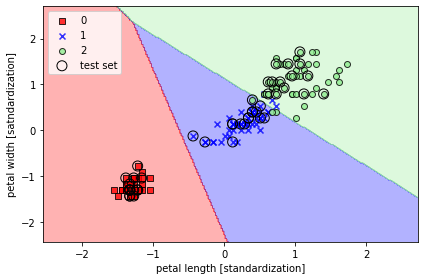

In [1]:
# 연산 모듈
import numpy as np
# 그래프
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# 사이킷 런 
from sklearn import datasets
# 데이터 계층화
from sklearn.model_selection import train_test_split
# 데이터 표준화
from sklearn.preprocessing import StandardScaler
# 사이킷런 로지스틱 회귀 모델 불러오기
from sklearn.linear_model import LogisticRegression

# 2차원 데이터셋의 결정 경계를 시각화
def plot_decision_regions(X, y, classifier, test_idx = None, resolution = 0.02) :
    
    # 마커와 컬러맵 설정
    markers = ('s', 'x', 'o', '^', ' v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 결정 경계 그리기
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha = 0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도
    for idx, cl in enumerate(np.unique(y)) :
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha = 0.8, c = colors[idx], marker = markers[idx],
                   label = cl, edgecolor = 'black')
    
    # 테스트 샘플을 부각
    if test_idx : 
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1], c = '', edgecolor = 'black', alpha = 1.0,
                   linewidth = 1, marker = 'o', s = 100, label = 'test set')
        # s 는 마커 크기


# 데이터 가져오기
iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                   random_state = 1, stratify = y)

# 데이터 스케일 표준화
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# 훈련   
lr = LogisticRegression(solver = 'liblinear', multi_class = 'auto', C = 100.0, random_state = 1)
# 사이킷런 0.20 버전부터 LogisticRegression 클래스의 solver 매개변수 기본 값이 'liblinear' -> 'lbfgs'
# 로 변경됨.
# 사이킷런 0.20 버전부터 LogisticRegression의 multi_calss 매개변수 옵션에 'auto'가 추가됨.
# 'auto'는 이진 분류이거나 solver가 'liblinear'일 경우 'ovr'을 선택하고, 외에는 'multinomial'을 선택
# 사이킷런 0.22 버전부터 multi_class의 매개변수의 기본값이 'ovr'에서 'auto'로 변경됨
lr.fit(X_train_std, y_train)

# 샘플 결합
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# 그래프 그리기
plot_decision_regions(X_combined_std, y_combined, classifier = lr, test_idx = range(105, 150))
plt.xlabel('petal length [standardization]')
plt.ylabel('petal width [satndardization]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

In [17]:
# n 번째 행은 n 번째 붓꽃의 클래스 소속 확률
# 행에서 가장 큰 값의 열이 예측 클래스 레이블이 된다.
print(lr.predict_proba(X_test_std[:3, :]))

print('-----------')
# 모든 열을 더하면 1이 된다.
print((lr.predict_proba(X_test_std[:3, :])).sum(axis = 1))

print('-----------')
# argmax 함수로 확인
print(lr.predict_proba(X_test_std[:3, :]).argmax(axis = 1))
print('각각 Iris-virginica, Iris-setosa, Iris-setosa')

print('-----------')
# 조건부 확률로 부터 얻지 않고 predict로 빠르게 클래스 레이블을 확인할 수 있다.
print(lr.predict(X_test_std[:3, :]))

"""
사이킷런은 입력 데이터로 2차원 배열을 기대하므로,
하나의 행을 2차원 포맷으로 변경해야한다.

"""
lr.predict(X_test_std[0, :].reshape(1, -1))

[[3.17983737e-08 1.44886616e-01 8.55113353e-01]
 [8.33962295e-01 1.66037705e-01 4.55557009e-12]
 [8.48762934e-01 1.51237066e-01 4.63166788e-13]]
-----------
[1. 1. 1.]
-----------
[2 0 0]
각각 Iris-virginica, Iris-setosa, Iris-setosa
-----------
[2 0 0]


array([2])

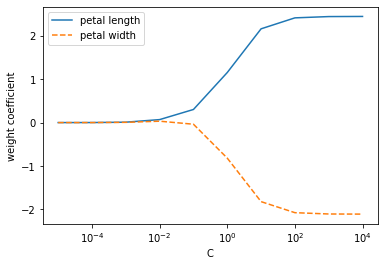

시연을 위해 모든 분류기에서 클래스 1의 가중치 값만 사용 (2번 째 클래스인 Iris-versicolor)
다중 분류에는 OvR 기법 사용
매개변수 C가 감소하면 가중치 절댓값이 줄어든다.


In [20]:
# 규제 매개변수 C의 효과 확인하기

weights, params = [], []
for c in np.arange(-5, 5) : 
    lr = LogisticRegression(solver = 'liblinear', multi_class = 'auto', C = 10.**c, random_state = 1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0], label = 'petal length')
plt.plot(params, weights[:, 1], linestyle = '--', label = 'petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc = 'upper left')
plt.xscale('log')
plt.show()

print('시연을 위해 모든 분류기에서 클래스 1의 가중치 값만 사용 (2번 째 클래스인 Iris-versicolor)')
print('다중 분류에는 OvR 기법 사용')
print('매개변수 C가 감소하면 가중치 절댓값이 줄어든다.')